# Actor-Critic Methods on Classic Gym Environments
## By Erin Gregoire & John Abramo
### Spring 2025

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from gymnasium.spaces import Box
import matplotlib.pyplot as plt
from collections import deque
import torch.multiprocessing as mp
import pickle
from multiprocessing import Lock
import matplotlib.image as mpimg
from walker import *

In [24]:
def run():
    env_name = "BipedalWalker-v3"
    action_discrete=False
    steps = 10000
    device = "cpu"

    temp_env = gym.make(env_name)
    input_dim = temp_env.observation_space.shape[0]
    action_dim = temp_env.action_space.shape[0]
    temp_env.close()

    global_agent = A2Cagent(None, input_dim, action_dim, device, action_discrete=False)
    global_agent.share_memory()

    threads = 2

    # need to protect the accesses to shared state
    lock = Lock()

    workers = []
    for i in range(threads):
        p = mp.Process(target=training_loop, args=(i, env_name, global_agent, steps, lock, action_discrete))
        workers.append(p)
        p.start()

    for w in workers:
        w.join()

    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    obs, info = env.reset()
    rewards = []
    for i in range(10):
        terminated, truncated = False, False
        ep_reward = 0
        timestep = 0
        while not (terminated or truncated):
            action = global_agent.forward_actor(obs)
            next_obs, reward, terminated, truncated, info = env.step(action.cpu().detach().numpy())
            ep_reward += reward
            timestep += 1
            obs = next_obs
        rewards.append(ep_reward)
        obs, info = env.reset()

    # save results
    create_pickle_file(global_agent.state_dict(), 'a3_part_3_walker_ergregoi_jmabramo.pkl')


In [25]:
if __name__ == "__main__":
    import multiprocessing as mp
    mp.set_start_method("spawn", force=True)
    run()

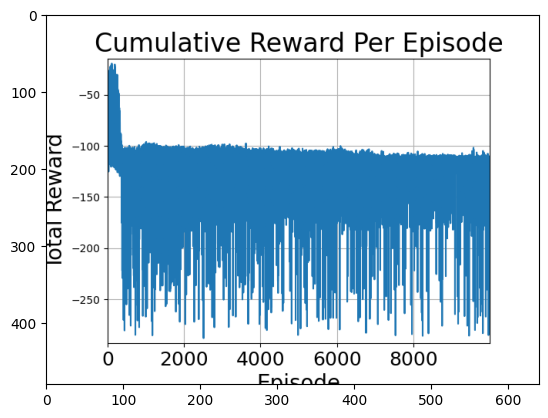

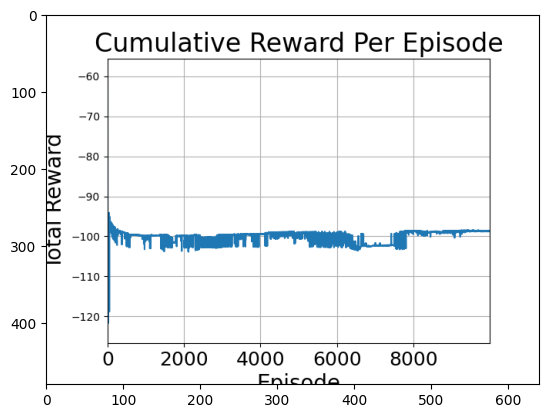

In [26]:
# training results:

img1 = mpimg.imread("walker_training_cumulative_reward_per_ep_0.png")
plt.imshow(img1)
plt.show()

img2 = mpimg.imread("walker_training_cumulative_reward_per_ep_1.png")
plt.imshow(img2)
plt.show()

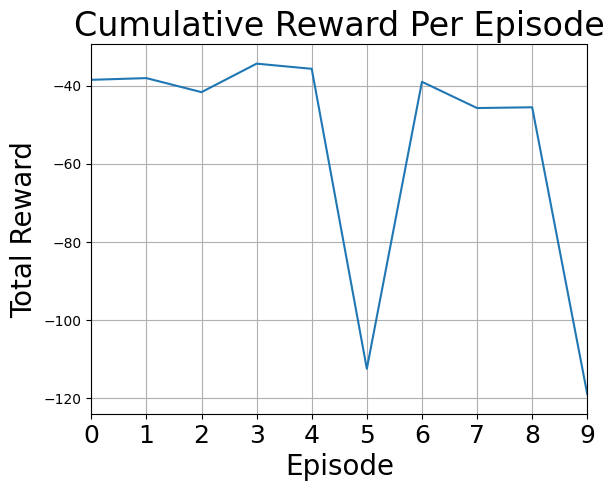

In [20]:
def eval_loop():
    env = gym.make("BipedalWalker-v3")
    action_discrete=False
    if action_discrete:
        input_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
    else:
        input_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
    agent=A2Cagent(env, input_dim, action_dim, device, action_discrete=action_discrete, pickle_file='a3_part_3_walker_ergregoi_jmabramo.pkl', greedy=True)
    episodes = 10
    gamma = 0.99
    optimizer = optim.Adam(agent.parameters(), lr=.001)
    cumulative_rewards = []

    for i in range(episodes):
        ep_reward = 0
        obs, info = env.reset()
            
        terminated, truncated = False, False
        while not (terminated or truncated):
            action = agent.forward_actor(obs)
            next_obs, reward, terminated, truncated, info = env.step(action.detach().numpy())
            ep_reward += reward
            obs = next_obs
        cumulative_rewards.append(ep_reward)

    # total reward per episode
    plt.figure()
    plt.plot(cumulative_rewards)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Total Reward', fontsize=20)
    plt.title('Cumulative Reward Per Episode', fontsize=24)
    plt.xticks(fontsize=18)
    plt.ylim(ymin=(min(cumulative_rewards)-5), ymax=(max(cumulative_rewards)+5))
    plt.xlim(xmin=0, xmax=episodes-1)
    plt.grid()

eval_loop()